## E-commerce Business Transaction Analytics
_source : https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business_

***

#### About the data:
This is a sales transaction data set of UK-based e-commerce (online retail) for one year. This London-based shop has been selling gifts and homewares for adults and children through the website since 2007. Their customers come from all over the world and usually make direct purchases for themselves. There are also small businesses that buy in bulk and sell to other customers through retail outlet channels.

The data set contains __500K rows__ and __8 columns__. The following is the description of each column.

 1) __TransactionNo__ (categorical): a six-digit unique number that defines each transaction. (_The letter “C” in the code indicates a cancellation_).

 2) __Date__ (numeric): the date when each transaction was generated.

 3) __ProductNo__ (categorical): a five or six-digit unique character used to identify a specific product.

 4) __Product__ (categorical): product/item name.

 5) __Price__ (numeric): the price of each product per unit in pound sterling (£).

 6) __Quantity__ (numeric): the quantity of each product per transaction. (_Negative values indicate cancelled transactions_).

 7) __CustomerNo__ (categorical): a five-digit unique number that defines each customer.

 8) __Country__ (categorical): name of the country where the customer resides.

There is a small percentage of __order cancellation__ in the data set. Most of these cancellations were due to out-of-stock conditions on some products. Under this situation, customers tend to cancel an order as they want all products delivered all at once.

----------

#### Overview - Expected research outcomes

Transaction data analysis is a process of examining and interpreting data collected from customer transactions in order to gain insights and make informed business decisions. For an e-commerce business, analyzing transaction data over the course of a year can help in several departments.

Given the scope of the data features provided in this dataset, we will focus our attention in the following:

-  Identifying sales seasonality / distribution of transactions over time,

-  Understanding the demographics and purchasing habits of the customers,

-  Insights concering product popularity/profitability,

-  Customer retention.


Overall, analyzing transaction data can provide valuable insights that can help an e-commerce business make data-driven decisions to improve its performance.

---------

####  Table of Contents

1) [Importing, cleaning and validating the data](#importing-cleaning-and-validating-the-data)

2) [Exploratory analysis - Understanding the data](#exploratory-analysis---understanding-the-data)

3) [RFM Analysis](#rfm-analysis)

4) [Pareto principle](#pareto-principle-on-customers)

5) [Market Basket Analysis](#market-basket-analysis)

6) [Cohort Analysis](#customer-retention-through-cohort-analysis)

-------

### Importing, cleaning and validating the data <a class="anchor" id="importing-cleaning-and-validating-the-data"></a>

#### Dependencies

In [125]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

#### Importing dataset into a pandas dataframe

In [126]:
df = pd.read_csv("Sales_Data.csv")

#### Dataframe overview

In [127]:
def data_report(dataframe):
    """ Function to get a dataframe review """
    print(dataframe.info())
    print("\n")
    print(dataframe.describe())
    print("\n")
    print(df.isnull().sum())

data_report(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB
None


               Price       Quantity     CustomerNo
count  536350.000000  536350.000000  536295.000000
mean       12.662182       9.919347   15227.893178
std         8.490450     216.662300    1716.582932
min         5.130000  -80995.000000   12004.000000
25%        10.990000       1.000000   13807.000000
50%        11.940000       3.000000   15152.000000
75%        14

#### Dropping duplicate rows

In [128]:
df.drop_duplicates(inplace=True)

#### Dropping rows with null values for the Customer_id feature

In [129]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

#### Renaming the columns in the dataframe

In [130]:
df.rename(columns={
"TransactionNo":"Transaction_id",
"ProductName":"Product_name",
"ProductNo":"Product_id",
"CustomerNo":"Customer_id"}, inplace=True)

#### Casting data in the Date column into datetime type

In [131]:
df["Date"] = pd.to_datetime(df["Date"])

### Exploratory analysis - Understanding the data <a class="anchor" id="exploratory-analysis---understanding-the-data"></a>

#### Finding the time range of the transactions recorded into the dataset

In [132]:
max_date = df["Date"].max()
min_date = df["Date"].min()
print(f'Earliest data log at: {min_date}')
print(f'Latest data log at: {max_date}')
print(f'Dataframe total time duration: {max_date - min_date}')

Earliest data log at: 2018-12-01 00:00:00
Latest data log at: 2019-12-09 00:00:00
Dataframe total time duration: 373 days 00:00:00


#### Adding the following features as columns in the dataframe:

 - Day

 - Month

 - Year

 - Day_name
 
 - Transaction_profit

In [133]:
df["Day"] = df["Date"].dt.day
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Day_name"] = df["Date"].dt.day_name()
df["Transaction_profit"] = df["Price"] * df["Quantity"]
df.head()

,Transaction_id,Date,Product_id,Product_name,Price,Quantity,Customer_id,Country,Day,Month,Year,Day_name,Transaction_profit
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,9,12,2019,Monday,257.64
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,9,12,2019,Monday,383.40
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,9,12,2019,Monday,138.36
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,9,12,2019,Monday,127.80
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,9,12,2019,Monday,71.64


#### Filtering out the data from December 2018, we will focus only on 2019 data forward

In [134]:
df = df[df["Year"] == 2019]

#### Validating which rows contain cancelled transactions

In [135]:
# Counting how many invalid transaction / cancelled are there through the Transaction_id values
number_tid_cancelled = df[df["Transaction_id"].str.contains("C", regex=True)].shape[0]

# Counting how many invalid transaction / cancelled are there through the Quantity values
number_q_cancelled = df[df["Quantity"]<0].shape[0]

if number_tid_cancelled == number_q_cancelled:
    print(f"There are {number_q_cancelled} rows of cancelled transactions in the dataframe.")
    print(f'These rows correspond to {df["Transaction_id"][df["Quantity"]<0].nunique()} unique transactions that got cancelled.')
else:
    print("Invalid data.")

There are 7831 rows of cancelled transactions in the dataframe.
These rows correspond to 3082 unique transactions that got cancelled.


#### Create a new dataframe containing only cancelled transactions out of the original dataframe

In [136]:
cancelled = df[df["Quantity"]<0].copy()

#### Distribution of transactions and cancellations per month of 2019

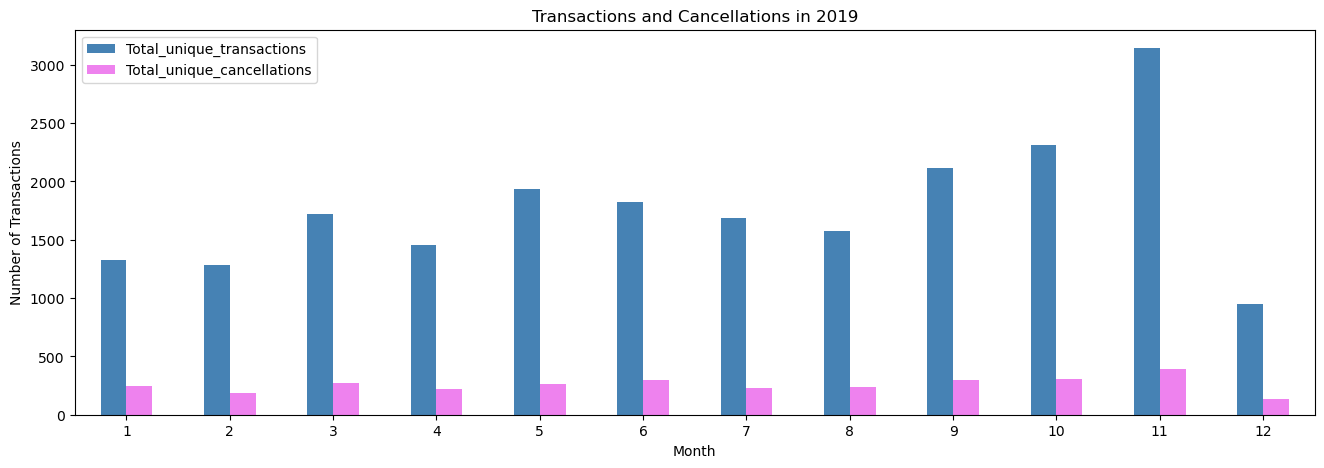

In [137]:
# Calculate the number of unique transactions per month 
monthly_transactions = df.groupby(by=["Month"]).agg({"Transaction_id":"nunique"})
monthly_transactions.rename(columns={"Transaction_id":"Total_unique_transactions"}, inplace=True)

# Calculate the number of unique cancellations per month 
monthly_cancellations = cancelled.groupby(by=["Month"]).agg({"Transaction_id":"nunique"}).rename({"Tansaction_id":"Unique_cancellations"})
monthly_cancellations.rename(columns={"Transaction_id":"Total_unique_cancellations"}, inplace=True)

# Create a new dataframe that contains total unique transactions, as well as the number of cancellations
total_monthy_transactions = pd.merge(monthly_transactions,monthly_cancellations, how="inner", on="Month")

# Ploting the results
total_monthy_transactions.plot.bar(figsize=[16,5], rot=0, title="Transactions and Cancellations in 2019", color=["steelblue","violet"])
plt.ylabel("Number of Transactions")
plt.show()


#### Filtering out cancelled transactions, we will focus only on valid purchases forward

In [138]:
df = df.drop(df[df["Quantity"]<0].index)

#### Distribution of completed transactions per month of 2019

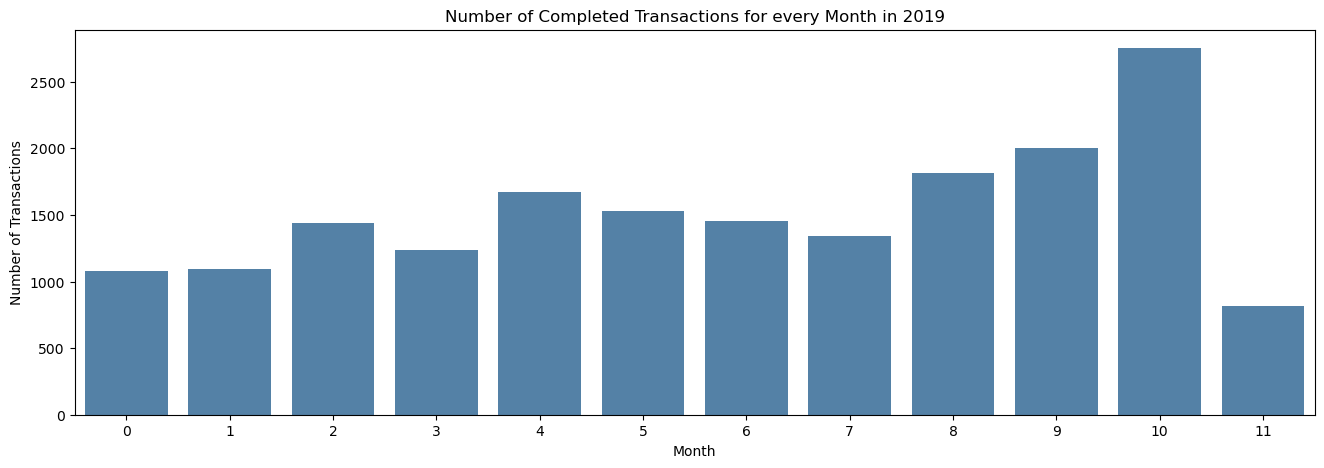

In [139]:
# How are transactions distributed in each month.
montlhy_valid_transactions = df.groupby(by = ["Month"]).agg({"Transaction_id": "nunique"}).reset_index()

# Plot the bar graph 
plt.figure(figsize=[16,5])
sns.barplot(data=montlhy_valid_transactions, x=montlhy_valid_transactions.index, y="Transaction_id", color="steelblue")

# Add title and labels
plt.title("Number of Completed Transactions for every Month in 2019")
plt.ylabel("Number of Transactions")
plt.xlabel("Month")
plt.show()

#### Transactions per day of each month for 2019

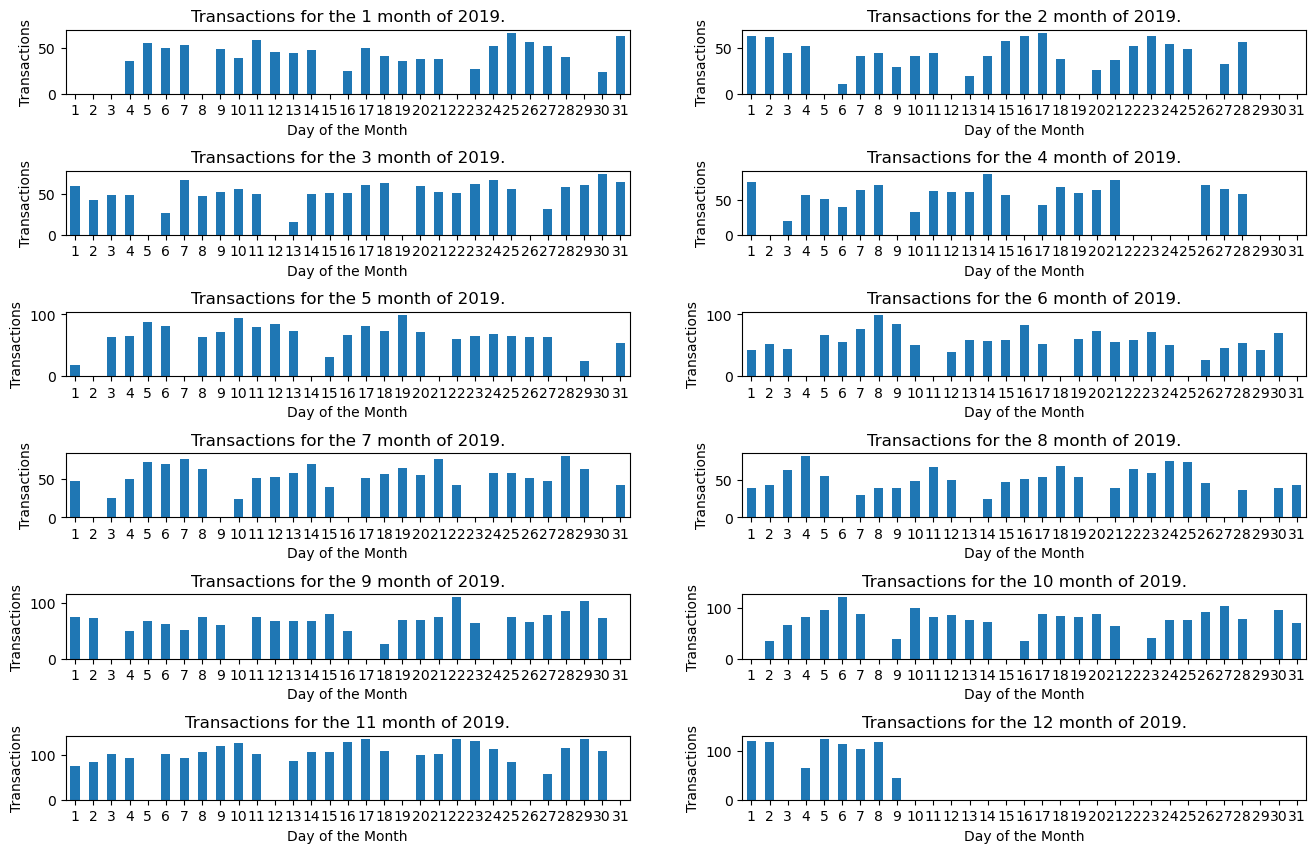

In [140]:
daily_transactions = df.groupby(by = ["Month","Day"]).agg({"Transaction_id": "nunique"})

# Plotting the transactions for every month of 2019
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=[16,10])
axs = axs.ravel()
for i, row in daily_transactions.unstack().iterrows():
    row.plot.bar(ax = axs[i-1], title = f"Transactions for the {i} month of 2019.", rot=0)
    axs[i-1].set_xticklabels(range(1,32))
    axs[i-1].set_xlabel("Day of the Month")
    axs[i-1].set_ylabel("Transactions")
plt.subplots_adjust(hspace=1.2)
plt.show()


#### Transactions per day of the week for 2019

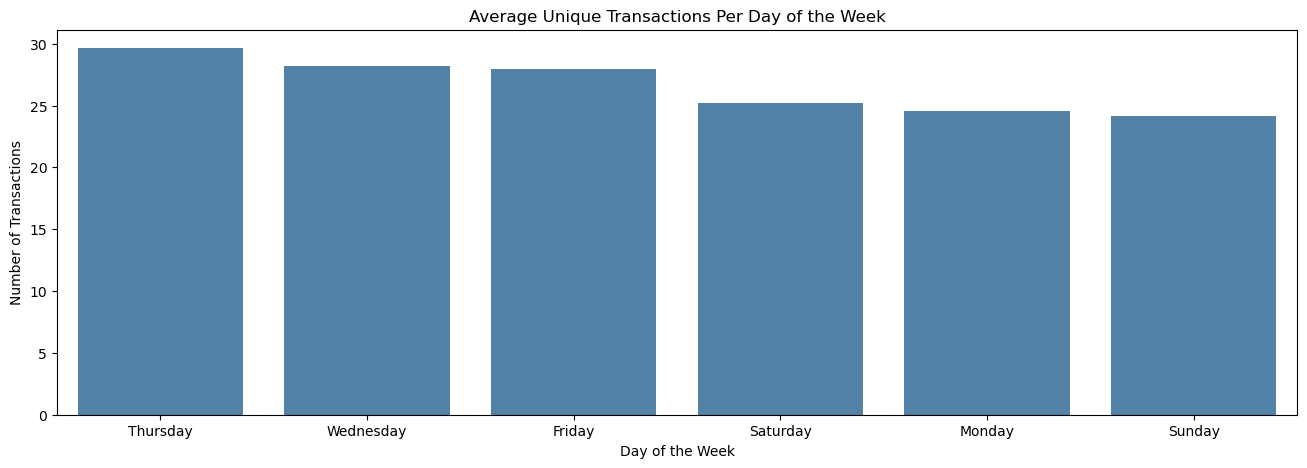

In [141]:
unique_daily_transactions = df.groupby(by=["Day_name","Transaction_id"])["Transaction_id"].count().reset_index(name="Transaction_count")
mean_daily_transactions = unique_daily_transactions.groupby(by=["Day_name"])["Transaction_count"].mean().sort_values(ascending=False)

# Plot the bar graph
plt.figure(figsize=[16,5])
sns.barplot(x=mean_daily_transactions.index, y=mean_daily_transactions.values, color="steelblue")

# Add title and labels
plt.title("Average Unique Transactions Per Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Transactions")
plt.show()

#### It should be highlighted that there are no transaction data for Tuesdays.

#### 10 dates with the most transactions in 2019

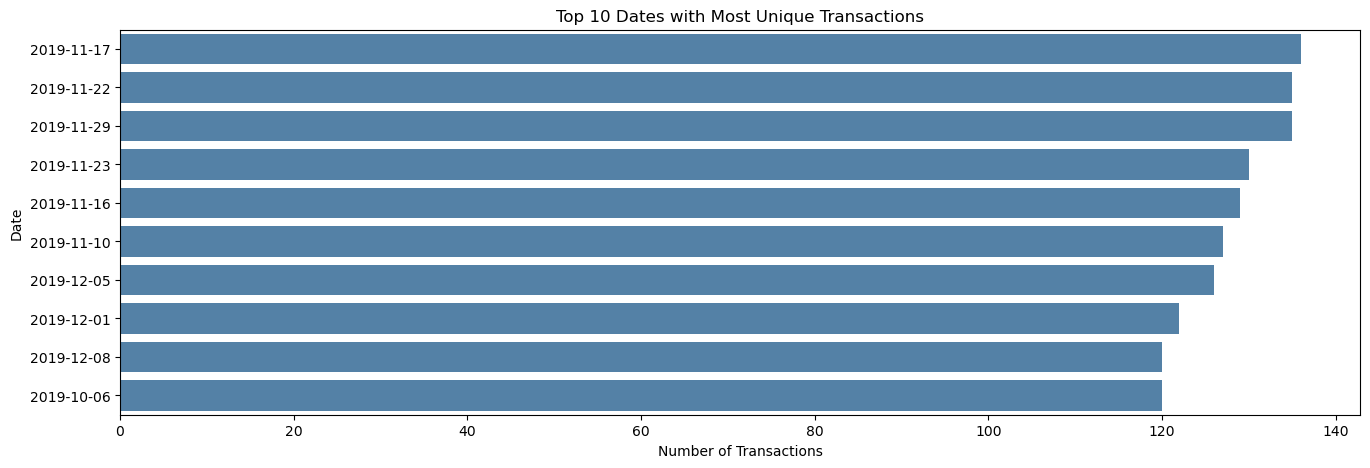

In [142]:
daily_transactions = df.groupby(by = ["Date"])["Transaction_id"].nunique()
daily_transactions.sort_values(ascending=False, inplace=True)
top_ten = daily_transactions[:10]

# Plot the bar graph using seaborn
plt.figure(figsize=[16,5])
sns.barplot(x=top_ten.values, y=top_ten.index.date, orient="h", color="steelblue")

# Add title and labels
plt.title("Top 10 Dates with Most Unique Transactions")
plt.xlabel("Number of Transactions")
plt.ylabel("Date")
plt.show()

#### 10 dates with the least transactions in 2019

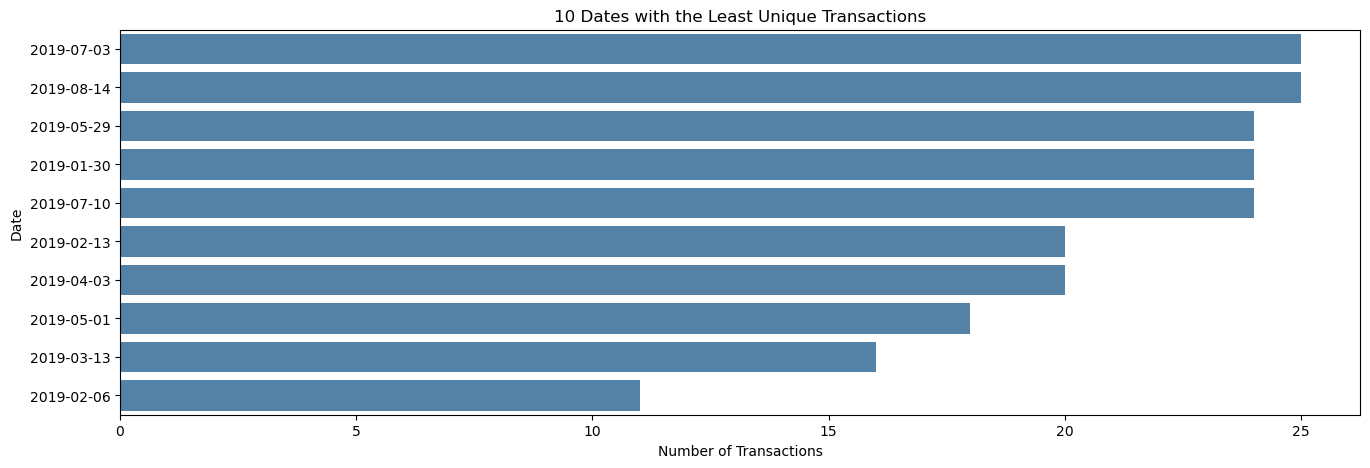

In [143]:
bottom_ten = daily_transactions[len(daily_transactions)-10:]

# Plot the bar graph
plt.figure(figsize=[16,5])
sns.barplot(x=bottom_ten.values, y=bottom_ten.index.date, orient="h", color="steelblue")

# Add title and labels
plt.title("10 Dates with the Least Unique Transactions")
plt.xlabel("Number of Transactions")
plt.ylabel("Date")
plt.show()

#### Number of unique products in the dataframe

In [144]:
unique_products =  df["Product_id"].nunique()
print(f"There are {unique_products} unique products in the dataframe.")

There are 3676 unique products in the dataframe.


#### Product prices boxplot

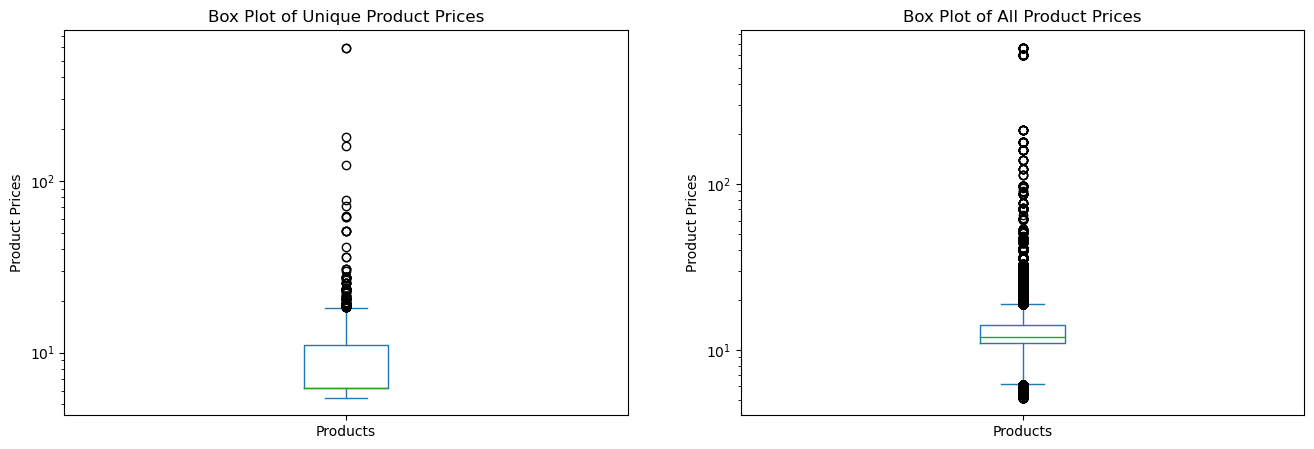

In [145]:
unique_products = df.drop_duplicates(subset=["Product_id"])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5])

unique_products["Price"].plot.box(ax=ax1)
ax1.set_title("Box Plot of Unique Product Prices")
ax1.set_ylabel("Product Prices")
ax1.set_yscale("log")
ax1.set_xticklabels(["Products"])

df["Price"].plot.box(ax=ax2)
ax2.set_title("Box Plot of All Product Prices")
ax2.set_ylabel("Product Prices")
ax2.set_yscale("log")
ax2.set_xticklabels(["Products"])

plt.show()

#### It is apparent that the products in the dataset have been sold throughout the year in different prices.

#### Distribution of price values among the products

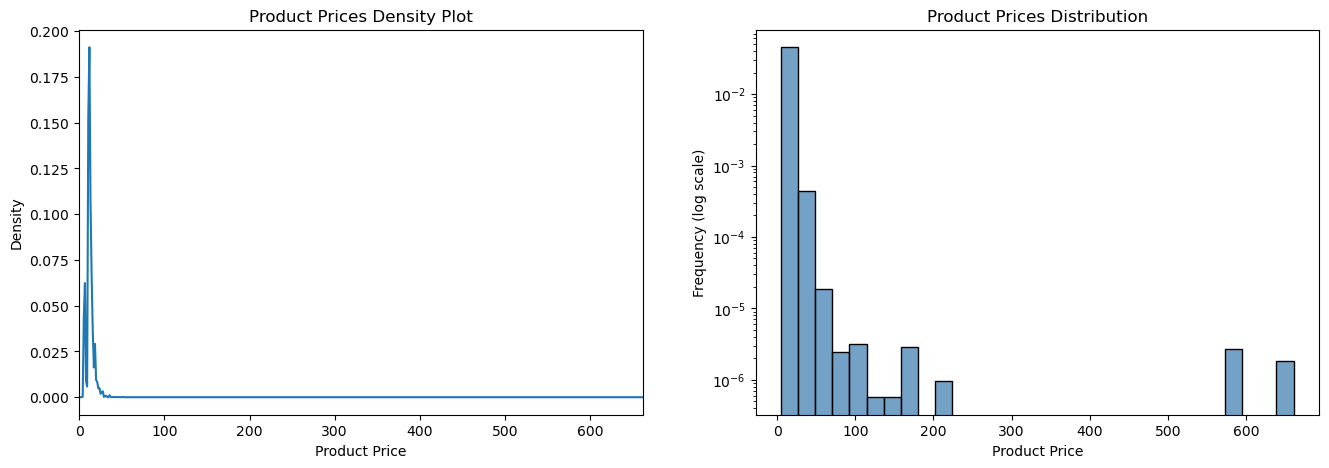

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5])

ax1 = df["Price"].plot.density(ax=ax1)
ax1.set_xlim(0,df["Price"].max()+1)
ax1.set_title("Product Prices Density Plot")
ax1.set_xlabel("Product Price")

ax2 = sns.histplot(df["Price"], bins=30, color="steelblue", stat="density", ax=ax2)
ax2.set_title("Product Prices Distribution")
ax2.set_xlabel("Product Price")
ax2.set_yscale("log")
ax2.set_ylabel("Frequency (log scale)")

plt.show()

In [147]:
same_product_prices = df.groupby(by=["Product_id"])["Price"].nunique()
same_product_prices = same_product_prices.sort_values(ascending = False)
same_product_prices = same_product_prices[same_product_prices.values>1]

print(f'Out of all the unique products in the dataset, {len(same_product_prices)} products appear to have been sold \nat more than one different prices.')
print(f'The product with id: {same_product_prices.index[0]} appears to has the highest variety of prices with {same_product_prices[0]} different prices.')

Out of all the unique products in the dataset, 3328 products appear to have been sold 
at more than one different prices.
The product with id: 79321 appears to has the highest variety of prices with 22 different prices.


#### Analyzing the price ranges for products with more than one recorded price

In [148]:
# Group the data by 'Product_id' and calculate the range of the 'Price' column for each group
price_ranges = df.groupby(by=["Product_id"]).agg({"Price":lambda x: x.max()-x.min()}).rename(columns={"Price":"Price_range"})

# Filter the dataframe to keep only products with more than one price
price_ranges = price_ranges[price_ranges["Price_range"] != 0]
price_ranges.sort_values(by = ["Price_range"], ascending=False, inplace=True)
print("List of top 5 products with the widest range of prices \n")
print(price_ranges.head())
print("\n List of top 5 products with the smallest range of prices \n")
print(price_ranges.tail())

List of top 5 products with the widest range of prices 

            Price_range
Product_id             
22826            203.93
23064             92.21
84078A            82.52
21473             82.01
21686             75.13

 List of top 5 products with the smallest range of prices 

            Price_range
Product_id             
20774              0.02
85086A             0.02
90123C             0.01
90001D             0.01
21801              0.01


#### Even though the price ranges are largely in the range of under a sterling, there are some notable outliers with products
#### that appear to have been sold with a price gap of around 200 sterlings.

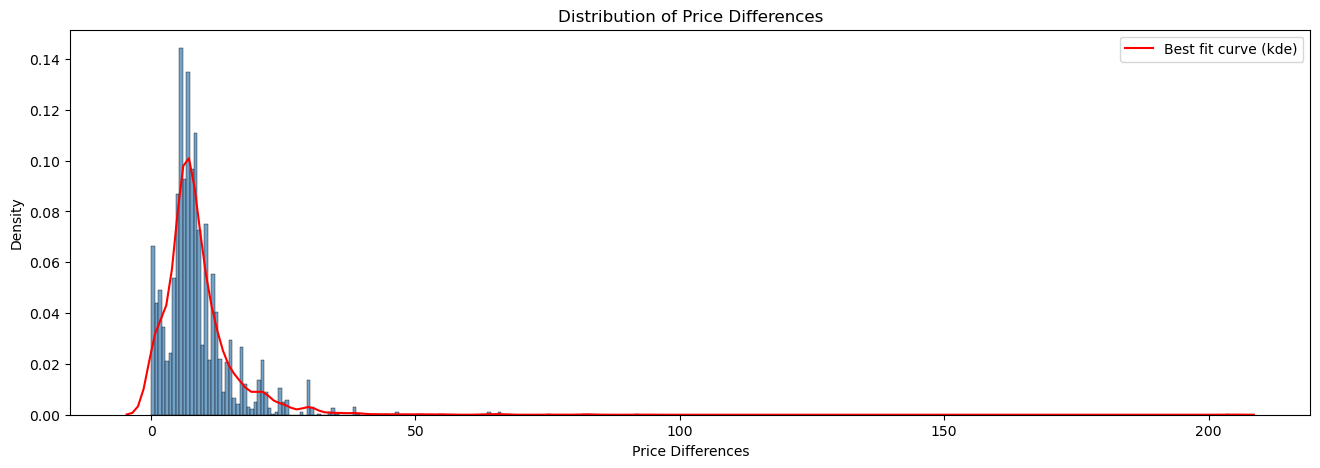

In [149]:
# Plotting the distribution of the recorded price ranges among same products
plt.figure(figsize=(16,5))
sns.histplot(price_ranges["Price_range"], color="steelblue", stat="density")
sns.kdeplot(price_ranges["Price_range"], color="red", label="Best fit curve (kde)")
plt.title("Distribution of Price Differences")
plt.xlabel("Price Differences")
plt.legend()
plt.show()

#### Examining the customer demographics

In [150]:
# Calculating number of customers per unique country in dataframe
demographics =  df.groupby(by=["Country"])["Customer_id"].nunique()
demographics.sort_values(inplace=True)

# Calculating region specific demographics
total_non_uk = demographics[demographics.index != "United Kingdom"].values.sum()
total_uk = demographics[demographics.index == "United Kingdom"].values

total_global = total_non_uk + total_uk

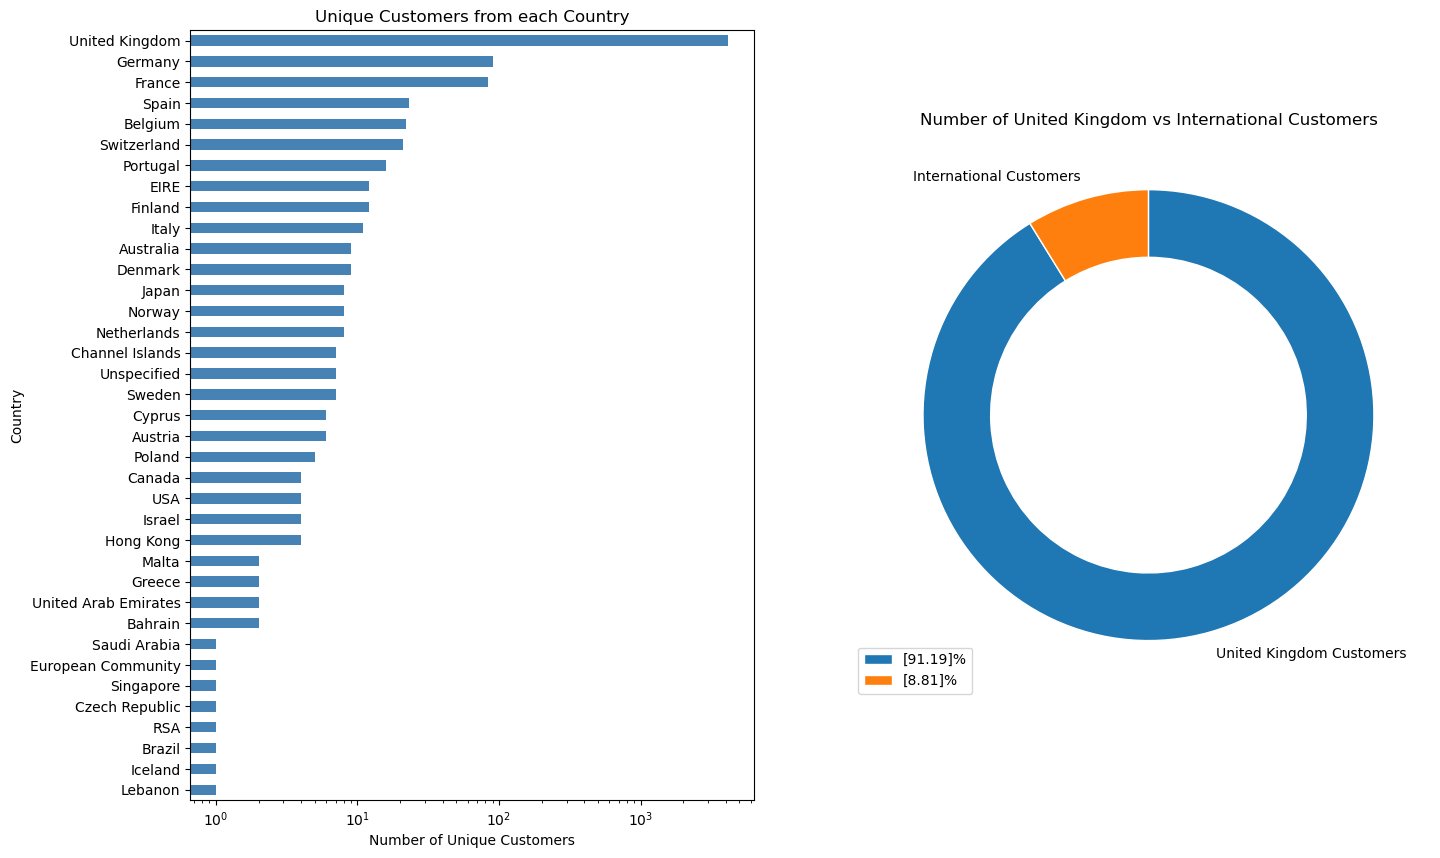

In [151]:
# Plotting the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,10])

# Horizontal bar plot
ax1 = demographics.plot.barh(color="steelblue", ax=ax1)
ax1.set_xscale("log")
ax1.set_xlabel("Number of Unique Customers")
ax1.set_title("Unique Customers from each Country")

# Draw the pie chart
ax2 = plt.pie([total_uk,total_non_uk],labels=["United Kingdom Customers", "International Customers"],
startangle=90, counterclock=False, wedgeprops=dict(width=0.3, edgecolor="w"))
plt.title("Number of United Kingdom vs International Customers")

# Add a legend with percentages on the pie chart
plt.legend([f"{np.round(total_uk/total_global *100,2)}%", f"{np.round(total_non_uk/total_global * 100,2)}%"],
bbox_to_anchor=(0.2, 0.1))

plt.show() 

In [152]:
# Add a new feature column to identify domestic from international customers
df["Domestic"] =  df["Country"].apply(lambda x: x=="United Kingdom")

#### Monthly revenue for 2019 from Domestic and International Transactions

In [153]:
# Calculate monthly revenue
monthly_revenue = df.groupby(by=["Month","Domestic"]).agg({"Transaction_profit":np.sum})

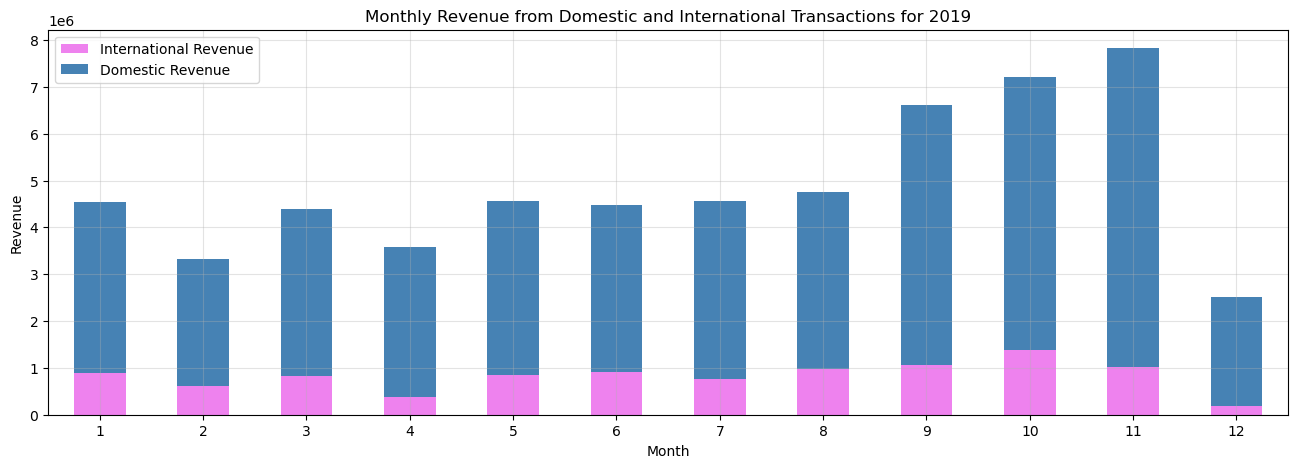

In [154]:
# Plotting Monthly Revenue from both Domestic and International Customers
monthly_revenue.unstack().plot.bar(stacked=True, rot=0,figsize=[16,5], color=["violet","steelblue"])
plt.title("Monthly Revenue from Domestic and International Transactions for 2019")
plt.ylabel("Revenue")
plt.legend(["International Revenue", "Domestic Revenue"])
plt.grid(alpha=0.35)
plt.show()

#### Daily revenue for 2019 from Domestic and International Transactions

In [155]:
# Calculate daily revenue, domestic and international
daily_revenue = df.groupby(by=["Date","Domestic"]).agg({"Transaction_profit":np.sum})

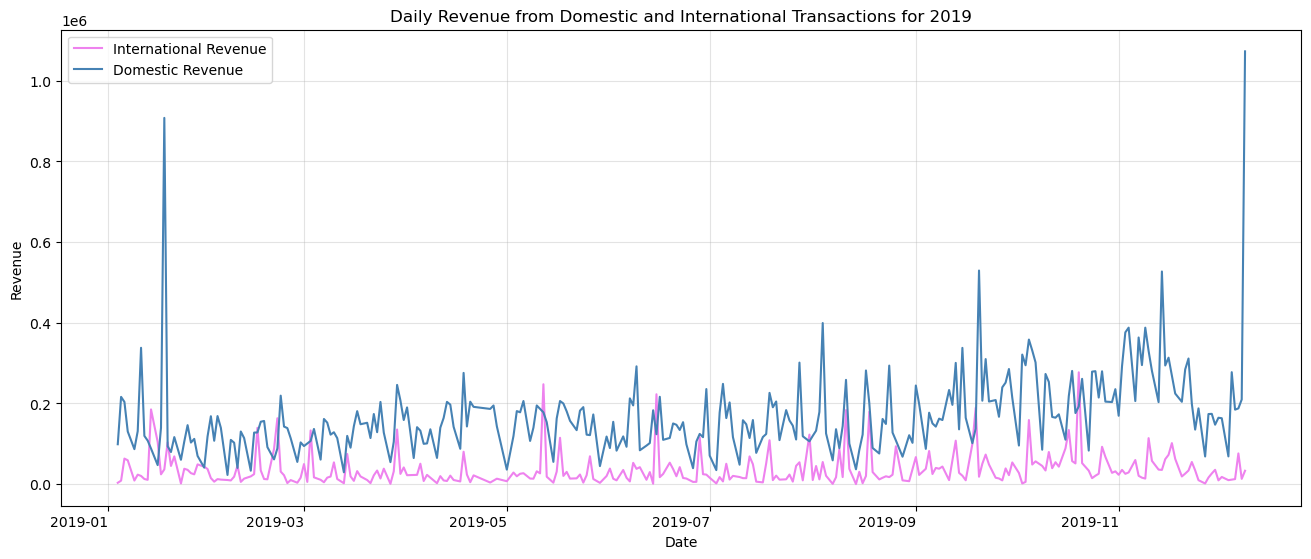

In [156]:
# Plot the daily revenue from Domestic and International transactions - used built in interpolation for missing dates
daily_revenue.unstack().interpolate().plot.line(rot=0,figsize=[16,7], color=["violet","steelblue"])
plt.title("Daily Revenue from Domestic and International Transactions for 2019")
plt.ylabel("Revenue")
plt.legend(["International Revenue", "Domestic Revenue"])
plt.grid(alpha=0.35)
plt.show()

In [174]:
# Add a regression line for each of the timeseries for total daily transactions 
global_daily_revenue = df.groupby(by=["Date"]).agg({"Transaction_profit":np.sum}).rename(columns={"Transaction_profit":"Revenue"})
global_daily_revenue

,Revenue
Date,
2019-01-04,102158.04
2019-01-05,224901.37
2019-01-06,267053.40
2019-01-07,189507.91
2019-01-09,95529.21
...,...
2019-12-05,288765.67
2019-12-06,197034.90
2019-12-07,263857.24


#### Examining December 2019 large spike in revenue

In [159]:
december = df[df["Month"]==12]
# total days of transactions
# average revenue per day
# number of unique customers
# pie chart domestic vs international customers (for count and revenue)

,Transaction_id,Date,Product_id,Product_name,Price,Quantity,Customer_id,Country,Day,Month,Year,Day_name,Transaction_profit,Domestic
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,9,12,2019,Monday,257.64,True
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,9,12,2019,Monday,383.40,True
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,9,12,2019,Monday,138.36,True
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,9,12,2019,Monday,127.80,True
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,9,12,2019,Monday,71.64,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25072,580137,2019-12-01,84347,Rotating Silver Angels T-Light Hldr,6.19,1,17566.0,United Kingdom,1,12,2019,Sunday,6.19,True
25073,580137,2019-12-01,23272,Tree T-Light Holder Willie Winkie,6.19,1,17566.0,United Kingdom,1,12,2019,Sunday,6.19,True
25074,580137,2019-12-01,23490,T-Light Holder Hanging Love Bird,6.19,1,17566.0,United Kingdom,1,12,2019,Sunday,6.19,True
25075,580137,2019-12-01,23553,Landmark Frame Camden Town,6.19,2,17566.0,United Kingdom,1,12,2019,Sunday,12.38,True


### RFM analysis <a class="anchor" id="rfm-analysis"></a>

In [ ]:
# rfm analysis overview

In [ ]:
df.head()

,Transaction_id,Date,Product_id,Product_name,Price,Quantity,Customer_id,Country,Day,Month,Year,Day_name,Transaction_profit
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,9,12,2019,Monday,257.64
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,9,12,2019,Monday,383.40
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,9,12,2019,Monday,138.36
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,9,12,2019,Monday,127.80
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,9,12,2019,Monday,71.64


In [ ]:
class RFM:

    """ A class for RFM analysis on customers of the dataframe. """

    def __init__(self, data):
      """ RFM class constructor. Input arg: A pandas dataframe. """
      self.data = data

    def calculate_recency(self):
      """ Method to calculate recency for each transaction in the dataframe. """
      max_date = self.data["Date"].max()
      self.data["recency"] = (max_date - self.data["Date"]).dt.days

    def calculate_frequency(self):
      """ Method to calculate frequency for each customer in the dataframe. """
      frequency = self.data.groupby("Customer_id").agg({"Date":"count"})
      self.data = self.data.merge(frequency, on="Customer_id")

    def calculate_monetary_value(self):
      """ Method to calculate monetary_value for each customer in the dataframe. """
      monetary = self.data.groupby("Customer_id").agg({"-------": "sum"})
      self.data = self.data.merge(monetary, on="Customer_id")

    def calculate_rfm(self):
      """ Method to create new columns in the dataset for recency, frequenct and monetary_value. """
      self.calculate_recency()
      self.calculate_frequency()
      self.calculate_monetary_value()
    
    def segment_customers(self):
      """ Method to produce segments of customers for different RFM groups and return the updated dataframe. """
      self.calculate_rfm()
      self.data["r_quartile"] = pd.qcut(self.data["recency"], q=4, labels=range(1,5))
      self.data["f_quartile"] = pd.qcut(self.data["frequency"], q=4, labels=list(range(4, 0, -1)))
      self.data["m_quartile"] = pd.qcut(self.data[""], q=4, labels=range(1,5))
      self.data["RFM_score"] = self.data[["r_quartile","f_quartile","m_quartile"]].sum(axis=1)
      return self.data
        


#rfm = RFM(data)
#df = rfm.segment_customers()

### Pareto principle (on customers) <a class="anchor" id="pareto-principle-on-customers"></a>

In [ ]:
# pareto overview

### Market Basket Analysis <a class="anchor" id="market-basket-analysis"></a>

In [ ]:
#mba overview

### Customer retention through Cohort Analysis <a class="anchor" id="customer-retention-through-cohort-analysis"></a>

In [ ]:
# cohort overview